High level story:

1. word cloud and barriers number histogram - what barriers do learners face? 
2. correlation, how do these barriers relate to each other? can we explore these relationships in more detail?
3. Likert diagrams to explore differences between programs/ regions, highlight interesting findings
4. visualise the flow of grads from bootcamp to 6months post-bootcamp. does placement speed vary per region? per programme? and how do the barriers factor in?

Questions for clarification: 
- what barriers/ metrics is the feature "barriers value" based on?


# Generation Exploratory Data Analysis
####   Megan Guidry | March 2024 

In [905]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import plotly.graph_objects as go

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from pandas.api.types import CategoricalDtype
from scipy import stats

## Objective

Generation UK&I has a mission to get disadvantaged people into sustainable careers that would otherwise be unattainable. This Jupyter notebook explores the demographics and barriers faced by Generation learners.

#### Assumptions
I am assuming this audience values diversity in tech. My audience is interested to understand the challenges that arise when recruiting, training, and employing people who have various employment barriers to overcome. This analysis could be used to motivate improvements to operational processes such that Generation:
- Recruits learners with a genuine need for carrer support
- Trains learners sufficiently for their chosen tech career, and
- Supports graduates through to employment as quickly as possible after bootcamp graduation.

#### Guiding Questions 
1. How many barriers does the typical Generation lerner face? What do these barriers look like?
2. How do these barriers correlate with each other and with other learner fetures at an individual level? How can this data help Generation staff better support Generation learners while on bootcamp and during placement phase?
3. What does the distribution of these barriers look like at a program or regional level. Is it possible to identify any trends? 

#### The Dataset

- The original dataset has 2602 observations. Each observation represents a learner that has been admitted onto a Generation UK&I bootcamp.
- This analysis will focus on tech bootcamps. After removing non-tech bootcamps from the dataset there are 1917 observations.
- The original dataset included only one cohort of approximately 25 learners based in Dublin. The rest are based in the UK. I have removed the Dublin cohort from this analysis.
  
**Program Names:**
- Technology - Cloud Operations Engineer
- Technology - Data Engineering
- Data Analytics
- IT Support
- Tech Talent Accelerator - Software Engineering
- Google Cloud

## Data Cleaning

In [906]:
# Reading the data and combining the two data sources:
PowerBI_df = pd.read_csv("Gen_Data/data_improved_including DE_AWS.csv")
SF_df = pd.read_csv("Gen_Data/Grad_attendance_info.xls.csv")

SF_df.rename(columns={"Learner Name":"LearnerName"}, inplace=True) #renaming the column required for merging

gen_df = pd.merge(PowerBI_df, SF_df, left_on='LearnerName', right_on='LearnerName')

In [907]:
# Filter the data so that we are only looking at tech programmes:
gen_df = gen_df[gen_df["ProgramName"].isin(["Technology - Cloud Operations Engineer", 
                                                 "Technology - Data Engineering", 
                                                 "Data Analytics", "IT Support", 
                                                 "Tech Talent Accelerator - Software Engineering", 
                                                 "Google Cloud"])]

# Filter data so that we are only looking at individuals that have graduated more than 180 days ago:
gen_df = gen_df[gen_df["Days Since Cohort Graduation"] >= 180]

In [908]:
# Remove Dublin, this is the only Irish cohort and is an outlier in the dataset:
gen_df = gen_df.drop(gen_df[gen_df["Cohort_City"]=="Dublin"].index)

In [909]:
# Clean "learnerSpecialNeedsDetails" before creating a wordcloud:

Needs_clean = gen_df[["learnerSpecialNeedsDetails", "ProgramName"]].dropna()
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="No"].index)
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="NIL"].index)
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="Non"].index)
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="NONE"].index)
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="nan"].index)

In [910]:
def find_text(x):
    if x != 0:
        return 1
    else:
        return 0

In [911]:
gen_df["learnerSpecialNeedsDetails_bool"] = gen_df["learnerSpecialNeedsDetails"].fillna(0)
gen_df["learnerSpecialNeedsDetails_bool"] = gen_df["learnerSpecialNeedsDetails_bool"].replace(to_replace= ["No", "NIL", "Non", "NONE", "nan"],
                                                                                              value= 0)
gen_df["learnerSpecialNeedsDetails_bool"] = gen_df["learnerSpecialNeedsDetails_bool"].apply(find_text)

In [912]:
def find_women_and_nb(x):
    if x in ["Female", "Non-binary", "Other"]:
        return 1
    else:
        return 0

In [913]:
gen_df["gender_bool"] = gen_df["gender"].apply(find_women_and_nb)

In [914]:
# replace nans in enrolment status with "Unknown"
# replace nans in employed within 90 days with 0

gen_df["Enrolment_Status"].fillna("Unknown Enrolment", inplace=True)
gen_df["Employment_Status"].fillna("Unknown Employment", inplace=True)

gen_df["Employed_within_90D"].fillna(0, inplace=True)
gen_df["Employed_within_90D_text"] = gen_df["Employed_within_90D"].replace(to_replace= [0, 1],
                                                                           value= ["Not employed 90D", "Employed 90D"])

gen_df["Employed_within_180D"].fillna(0, inplace=True)
gen_df["Employed_within_180D_text"] = gen_df["Employed_within_180D"].replace(to_replace= [0, 1],
                                                                           value= ["Not employed 180D", "Employed 180D"])

gen_df["Ethnicity_Group"].fillna("Not disclosed", inplace=True)

In [915]:
gen_df["Employment_Status"]= gen_df["Employment_Status"].replace(to_replace= ["Placed", "Unknown", "Internship"],
                                    value= ["Employed", "Unknown Employment", "Employed"])

In [916]:
gen_df["Ethnicity_Group"] = gen_df["Ethnicity_Group"].replace(to_replace= "Roma, Gypsy or Irish traveller",
                                                              value= "Other")

In [917]:
gen_df["gender"] = gen_df["gender"].replace(to_replace= ["Other/Prefer to self describe", "Choose not to identify"],
                                            value= ["Other", "Prefer not to say"])

In [982]:
gen_df["Graduation_year_month"] = gen_df["Graduation Date"].dt.to_period("M")

##### cleaning specific features ahead of heatmap correlation analysis

There are quite a lot of missing data in this dataset. for that reason I have carefully selected features that are as complete as possible to use for the correlation analysis. The features that were excluded from this portion of the EDA due to high numbers of NaN valuse include:

Features excluded from heatmap analysis due to large % of NaN:
- is_low_socio_econ
- is_unempl_12+_mths
- is_unemployed_pre_gen
- Job_start_speed
- socioeconStatusMap - needs ordinality assigned
- Average Score - Soft Skills
- Average Score - Technical Skills

Features included:
- asylumSeeker*
- Barriers value
- Education level
- has_degree
- Has_dependents*
- IMD_decile*
- Is_30_or_over
- Is_disabled
- is_EAL
- is_ethnic_minority*
- is_LGBTQ+*
- is_lone_parent*
- Days Since Cohort Graduation
- Total Days Absent
- Total Days Late

The features that have a star need data imputed. For most of these features (asylumSeeker, Has_dependents, is_ethnic_minority, is_LGBTQ, is_lone_parent) replaceing a null value with 0 is sufficient. This is because assigning a value of zero is equivalent to assuming this individual does not have this barrier. The error and bias from incorrectly lableing someone as having the barrier is greater than if we incorrectly lable someone as lacking the barrier. Aditionally, removing the rows completely would remove valuable data from other columns.

Data imputation for the feature IMD_decile will be handled separately.

In [918]:
# cleaning specific features ahead of heatmap correlation analysis:
# asylumSeeker, Has_dependents, is_ethnic_minority, is_LGBTQ+, is_lone_parent

# Cleaning asylumSeeker:
gen_df["asylumSeeker"].fillna("No", inplace=True)

# Cleaning Has_dependents:
gen_df["Has_dependents"].fillna(0, inplace=True)

# Cleaning is_ethnic_minority
gen_df["is_ethnic_minority"].fillna(0, inplace=True)

# Cleaning is_LGBTQ+
gen_df["is_LGBTQ+"].fillna(0, inplace=True)

# Cleaning is_lone_parent
gen_df["is_lone_parent"].fillna(0, inplace=True)


## Exploratory Data Analysis

#### 1. What barriers do Generation UK & I learners face?

In this analysis we look specifically into 15 different situational or demographic barriers:
-   asylumSeeker                            
-   Education level                         
-   gender                                  
-   has_degree                              
-   Has_dependents                          
-   IMD_decile                              
-   Is_30_or_over                           
-   Is_disabled                            
-   is_EAL                                 
-   is_ethnic_minority                      
-   is_LGBTQ+                               
-   is_lone_parent                         
-   is_low_socio_econ                       
-   is_unempl_12+_mths                      
-   is_unemployed_pre_gen

NOTE: The feature "Barriers value" is a count of all the barriers metrics that describe an individual learner.            

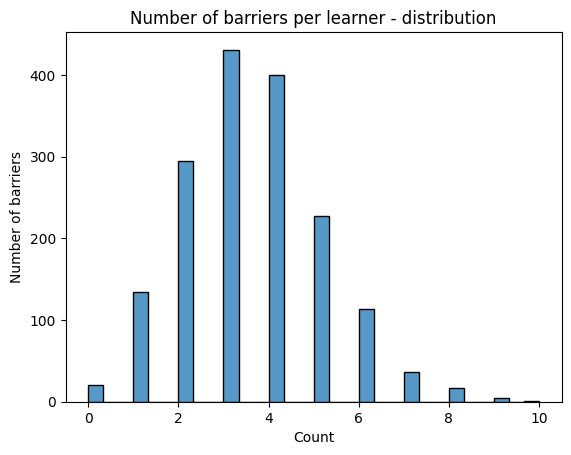

In [919]:
sns.histplot(data= gen_df, 
             x="Barriers value"
            )

plt.title("Number of barriers per learner - distribution")
plt.ylabel("Number of barriers")
plt.xlabel("Count")
plt.rcParams.update({'font.size': 14})
plt.show()

#### What special needs are most common among learners
The feature "learnerSpecialNeedsDetails" captures important information about the special needs that particular grad has. This is recorded by a generation staff member during the admissions process and helps staff understand how best to support this individual.

Note: Most learners do not have any special needs so this data is reflecting the minority that have disclosed this information to Generation.

In [920]:
# Learner special needs wordcloud:
@interact
def wordcloud_by_programme(Prog_name=Needs_clean["ProgramName"].value_counts().index.tolist()):
    text = " ".join(i for i in Needs_clean["learnerSpecialNeedsDetails"][Needs_clean["ProgramName"]==Prog_name].astype(str))
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

interactive(children=(Dropdown(description='Prog_name', options=('Technology - Data Engineering', 'IT Support'…

The wordcloud above shows that there is a clear theme among Generation learners who self-report having special needs. The most commonly disclosed special need that needs addressing is Depression and Anxiety. Autism and ADHD are relatively common as well. It is important to know that these barriers are not necessarily captured in the barriers count shown in the figure above and are often experienced in-addition to other demographic and situational challenges. Thus it is very important that learners who disclose special needs get the accomodations they need to succeed in the bootcamp.

#### 2. How do these barriers correlate with each other and with other learner fetures?

I will create a heatmap for visualising the relationships that exist between the barriers metrics. Before creating a heatmap in python there are three things I need to consider:
1. Handle missing data
2. remove outliers that may skew the results
3. assign ordinality to my categorical data where necessary 

##### Preparing my data for the heatmap

In [921]:
# Assigning ordinality to categorical features:

socioeconStatusMap_levels = CategoricalDtype(categories=["Exclude", "Lower socio-economic backgrounds", "Intermediate backgrounds", "Professional backgrounds"], ordered=True)
gen_df["socioeconStatusMap_ordered"] = gen_df["socioeconStatusMap"].astype(socioeconStatusMap_levels)

asylumSeeker_levels = CategoricalDtype(categories=["No", "Choose not to say", "Yes"], ordered=True)
gen_df["asylumSeeker_ordered"] = gen_df["asylumSeeker"].astype(asylumSeeker_levels)

gen_df["asylumSeeker_bool"] = gen_df["asylumSeeker"].replace(to_replace= ["No", "Choose not to say", "Yes"],
                                                                  value= [0, 0, 1])


In [922]:
# selecting the columns wanted for the heatmap and creating a df.

heatmap_df = gen_df[['asylumSeeker_bool', 
                     'Barriers value',
                     'Education level',
                     'has_degree', 
                     'Has_dependents',
                     'Is_30_or_over', 
                     'Is_disabled', 
                     'is_EAL', 
                     'is_ethnic_minority',
                     'is_LGBTQ+', 
                     'is_lone_parent', 
                     'Days Since Cohort Graduation',
                     'Total Days Absent', 
                     'Total Days Late',
                     'gender_bool',
                     'learnerSpecialNeedsDetails_bool'
                    ]]

In [923]:
# Extracting column names from the heatmap df
column_names=heatmap_df.columns

# Assiging column names to row indexs to create the matrix
chisqmatrix=pd.DataFrame(heatmap_df,columns=column_names,index=column_names)

In [924]:
# Setting counters to zero
outercnt=0
innercnt=0

for icol in column_names: # Outer loop
    for jcol in column_names: # inner loop
        # Converting to cross tab as for Chi-square test we have
        # to first convert variables into contigency table
        mycrosstab=pd.crosstab(heatmap_df[icol],heatmap_df[jcol])
        
        #Getting p-value and other usefull information
        stat,p,dof,expected=stats.chi2_contingency(mycrosstab)
        
        # Rounding very small p-values to zero
        # chisqmatrix.iloc[outercnt,innercnt]=round(p,5)
        chisqmatrix.loc[icol,jcol]=round(p,5)
        
        
        # # As mentioned above Expected frequencies should be at 
        # # least 5 for the majority (80%) of the cells.
        # # Here we are checking expected frequency of each group
        cntexpected=expected[expected<5].size
        
        # #Getting percentage 
        perexpected=((expected.size-cntexpected)/expected.size)*100

        # if perexpected<20:
        chisqmatrix.iloc[outercnt,innercnt]=2 #Assigning 2
         
        if icol==jcol:
            chisqmatrix.iloc[outercnt,innercnt]=0.00
            innercnt+=1
            outercnt+=1
            # innercnt=0

In [925]:
chisqmatrix = chisqmatrix.astype(float)

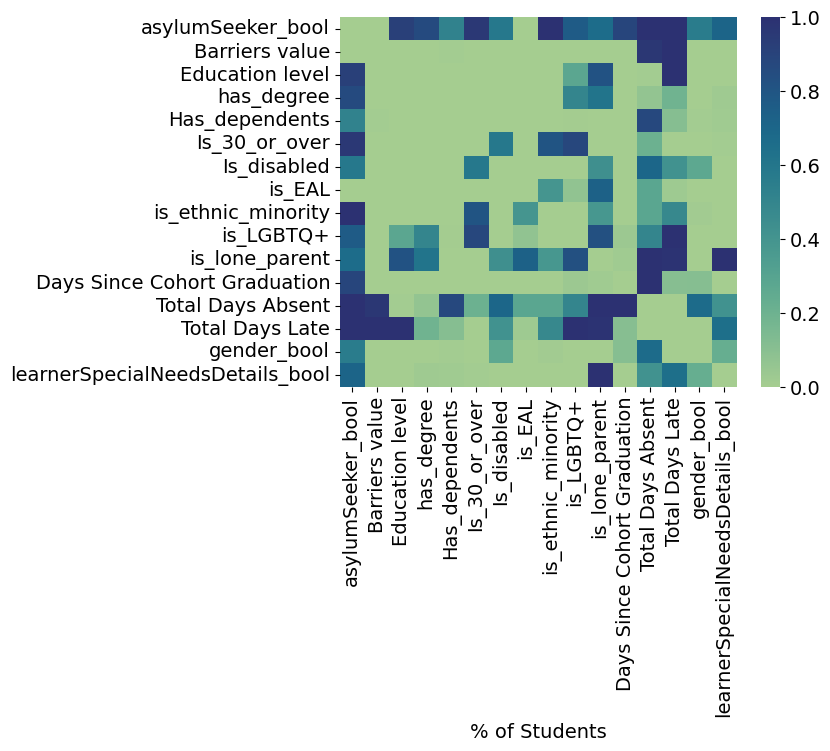

In [926]:
sns.heatmap(chisqmatrix, cmap="crest")

# show the graph
plt.ylabel("")
plt.xlabel("% of Students")
plt.rcParams.update({'font.size': 8})
plt.show()

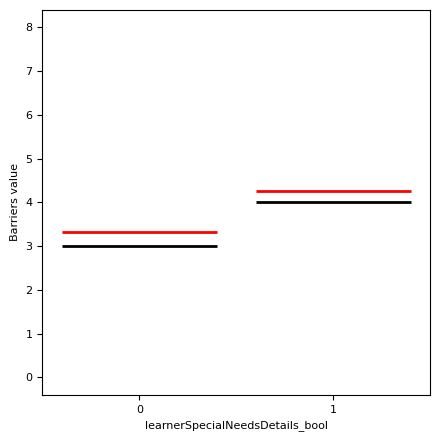

In [927]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))

# sns.stripplot(data=gen_df, 
#               x="Barriers value",
#               y="Total Days Late",
#               size= 3, 
#               jitter=0.35, 
#               ax=axs)

sns.boxplot(data=gen_df, 
            x="learnerSpecialNeedsDetails_bool",
            y="Barriers value",
            ax=axs, 
            meanprops={'visible': True, 'color': 'r', 'ls': '-', 'lw': 2},
            medianprops={'visible': True, 'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, 
            showmeans=True, meanline=True, showfliers=False, showbox=False, showcaps=False, zorder=10
           )

plt.show()

#### Are there program-specific trends in these barriers?

In [928]:
# Create a stacked bar chart:

@interact
def stacked_barchart(barrier=["Is_30_or_over", 
                              "Is_disabled", 
                              "is_EAL", 
                              "is_ethnic_minority", 
                              "is_LGBTQ+", 
                              "is_lone_parent", 
                              "is_low_socio_econ",
                              "is_unempl_12+_mths",
                              "is_unemployed_pre_gen",
                              "is_unsatisfied_empl_pre_gen",
                              "learnerSpecialNeedsDetails_bool",
                              "gender_bool"
                             ]):
    # import libraries
    import matplotlib.patches as mpatches
    
    # set the figure size
    fig = plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    
    # from raw value to percentage
    grads_per_programme_count = gen_df.groupby('ProgramName')['Student_ID'].count().reset_index()
    barrier_per_programme = gen_df.groupby('ProgramName')[barrier].sum().reset_index()
    barrier_per_programme[barrier] = [i / j * 100 for i,j in zip(barrier_per_programme[barrier], grads_per_programme_count['Student_ID'])]
    grads_per_programme_count['Student_ID'] = [i / j * 100 for i,j in zip(grads_per_programme_count['Student_ID'], grads_per_programme_count['Student_ID'])]
    
    # bar chart 1 -> top bars (group of 'smoker=No')
    bar1 = sns.barplot(y="ProgramName",  x="Student_ID", data=grads_per_programme_count, color='darkblue')
    
    # bar chart 2 -> bottom bars (group of 'smoker=Yes')
    bar2 = sns.barplot(y="ProgramName", x=barrier, data=barrier_per_programme, color='lightblue')
    
    # add legend
    top_bar = mpatches.Patch(color='darkblue', label=f'Not {barrier}')
    bottom_bar = mpatches.Patch(color='lightblue', label= f'{barrier}')
    plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor=(1.04, 1), loc="upper left")
    
    # show the graph
    plt.ylabel("")
    plt.xlabel("% of Students")
    plt.rcParams.update({'font.size': 24})
    plt.show()

interactive(children=(Dropdown(description='barrier', options=('Is_30_or_over', 'Is_disabled', 'is_EAL', 'is_e…

The figure above is showing how a particular barrier or leanrer characteristic is represented across the different Generation programmes. Here are some key findings:
- The AWS programme seems to attract a much younger crowd than the other programmes - is there room to expand recruitment activity for applicants over 30?
- Women + nonbinary individuals make up less than 40% of all technical programmes

#### does placement speed vary per region? per programme? and how do the barriers factor in?

In [929]:
def Sankey_data_preprocessing(feature_list, data, stop_points = None):
    # replace with feature_list
    
    source_ = [] 
    target_ = [] 
    value_ = []
    int_keys = {}
    temp_list = []
    
    # Create a complete list of sources and targets and convert to a dict:
    for x in feature_list:
        temp_list += gen_df[x].value_counts().index.tolist()

    for x in temp_list:
        int_keys[x] = temp_list.index(x)

    # Loop through each source feature in the provided list source_feature_list. 
    # Each loop represents one portion of the sanksey diagram:
    
    for i in range(len(feature_list)-1):
        # Make a list of the source values and target values for this part of the sankey diagram:
        source_values_str = data[feature_list[i]].value_counts().index.tolist()
        target_values_str = data[feature_list[i+1]].value_counts().index.tolist()

# fix the reference to target feature
        for source_val in source_values_str:
            for target_val in target_values_str:
                count_temp = data[data[feature_list[i+1]]==target_val].groupby(data[feature_list[i]]==source_val)[feature_list[i+1]].count()
                if True in count_temp:
                    count_temp = count_temp[True]
                    source_.append(int_keys[source_val])
                    target_.append(int_keys[target_val])
                    value_.append(count_temp)

    # # remove the exiting flows from the pre-defined stop_points:
    # if stop_points is not None:
    #     for x in stop_points:
    #         if int_keys[x] in source_:
    #             drop_index.append(source_.index(int_keys[x]))
    #         else:
    #             pass
    #         drop_index.sort(reverse=True)
    
    #     for x in drop_index:
    #         source_.pop(x)
    #         target_.pop(x)
    #         value_.pop(x)
    # else:
    #     pass

    labels_str = temp_list
    
    return source_, target_, value_, labels_str

In [930]:
def Sankey_plot(source_, target_, value_, labels=None, title_text_=None):
    
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = source_,
          target = target_,
          value = value_,
          hovercolor=["midnightblue", "lightskyblue", "gold", "mediumturquoise", "lightgreen", "cyan"],
      ))])

    # #Specify color for nodes 0, 1, 2, 3 and 4 in both source and target nodes
    # color_for_nodes = ["blue","blue","green","blue","blue", "blue", "blue", "blue", "blue", "blue","blue", "blue", "blue", "blue", "blue", "blue", "blue", "blue", "blue"]
    # fig.update_traces(node_color = color_for_nodes)
    
    fig.update_layout(title_text=title_text_, font_size=14)
    fig.show(renderer="iframe") 

In [931]:
data = gen_df
input_features= ["gender", "Employment_Status"]


source_, target_, value_, labels = Sankey_data_preprocessing(input_features, data, stop_points_)
Sankey_plot(source_, target_, value_, labels=labels, title_text_= "Employment outcomes per gender")

The figure above shows that Generation recruits less women and non-binary people than men for its tech bootcamps by a significant margin. The good news is that the Female, Non-binary graduates have a similar success rate in finding employment post-bootcamp.

In [932]:
data = gen_df
input_features= ["gender", "is_EAL"]


source_, target_, value_, labels = Sankey_data_preprocessing(input_features, data, stop_points_)
Sankey_plot(source_, target_, value_, labels=["Male", "Female", "Non-binary", "Other", "Prefer not to say", "Not EAL", "EAL"], title_text_= "EAL status per gender")

Approximately half of female students are EAL while just 30% of the Male students are EAL. Why are female generation students more likely to be EAL than male students? 

68.5% of Generation's tech bootcamp learners are men 
Over 50% of generation learners are native English-speaking Men

Despite major efforts to recruit female and non-binary learners onto bootcamps there is much room for improvement. 

In [933]:
EAL_genders = gen_df[gen_df["is_EAL"]==1]["is_EAL"].groupby(gen_df["gender"]).count()
nonEAL_genders = gen_df[gen_df["is_EAL"]==0]["Student_ID"].groupby(gen_df["gender"]).count()

EAL_gender_df = pd.concat([EAL_genders, nonEAL_genders], axis=1)
EAL_gender_df.rename(columns = {"is_EAL":"Is EAL", "Student_ID":"Is not EAL"}, inplace=True)

EAL_gender_df.style.background_gradient(axis=None, low=0.5, high=1)

,Is EAL,Is not EAL
gender,,
Female,226,275
Male,341,811
Non-binary,5,11
Other,2,4
Prefer not to say,4,1


In [934]:
gen_df["Graduation Date"].head()

56    06/11/2021
57     8/31/2022
58    10/31/2022
59    12/31/2022
60     1/23/2023
Name: Graduation Date, dtype: object

In [977]:
gen_df["Graduation Date"] = pd.to_datetime(gen_df["Graduation Date"])
gen_df["Graduation Date"].head()

56   2021-06-11
57   2022-08-31
58   2022-10-31
59   2022-12-31
60   2023-01-23
Name: Graduation Date, dtype: datetime64[ns]

In [981]:
gen_df["Graduation_month"] = gen_df["Graduation Date"].dt.month
gen_df["Graduation_year"] = gen_df["Graduation Date"].dt.year

gen_df["Graduation_year_month"] = gen_df["Graduation Date"].dt.to_period("M")
gen_df["Graduation_year_month"].head()

56    2021-06
57    2022-08
58    2022-10
59    2022-12
60    2023-01
Name: Graduation_year_month, dtype: period[M]

In [983]:
temp_df = gen_df.groupby("Graduation_year_month")["Employed_within_180D"].sum()

<Axes: xlabel='Graduation_year_month'>

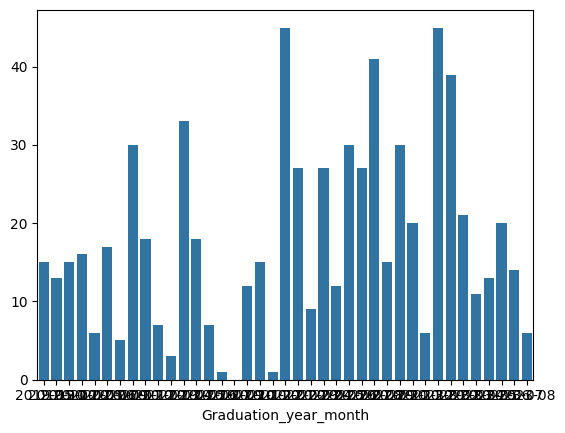

In [991]:
sns.barplot(x=temp_df.index, 
                y= temp_df.values)

In [958]:
gen_df["Graduation_month"] = gen_df["Graduation Date"].dt.month.astype(str)
gen_df["Graduation_month"] = gen_df["Graduation_month"].replace(to_replace= ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"],
                                                                value=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
                                                               )

grad_month_levels = CategoricalDtype(categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
gen_df["Graduation_month"] = gen_df["Graduation_month"].astype(grad_month_levels)

<Axes: xlabel='Count', ylabel='Graduation_month'>

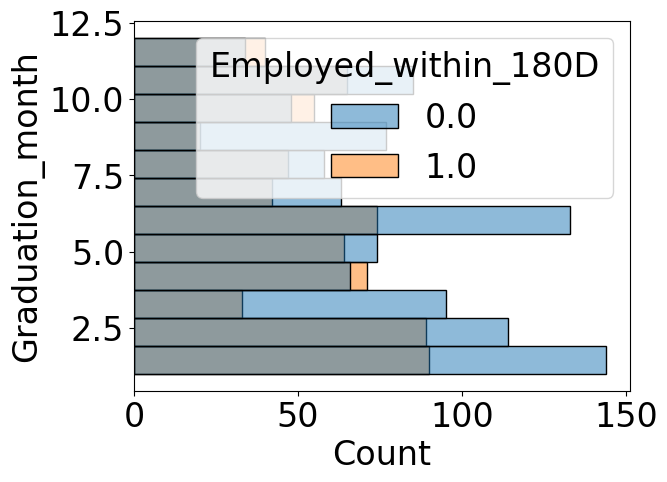

In [937]:
sns.histplot(y=gen_df["Graduation_month"],
            hue= gen_df["Employed_within_180D"])

/var/folders/62/rv9lbyxx6l110tffps2wcg2r0000gn/T/ipykernel_25786/972906079.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/62/rv9lbyxx6l110tffps2wcg2r0000gn/T/ipykernel_25786/972906079.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



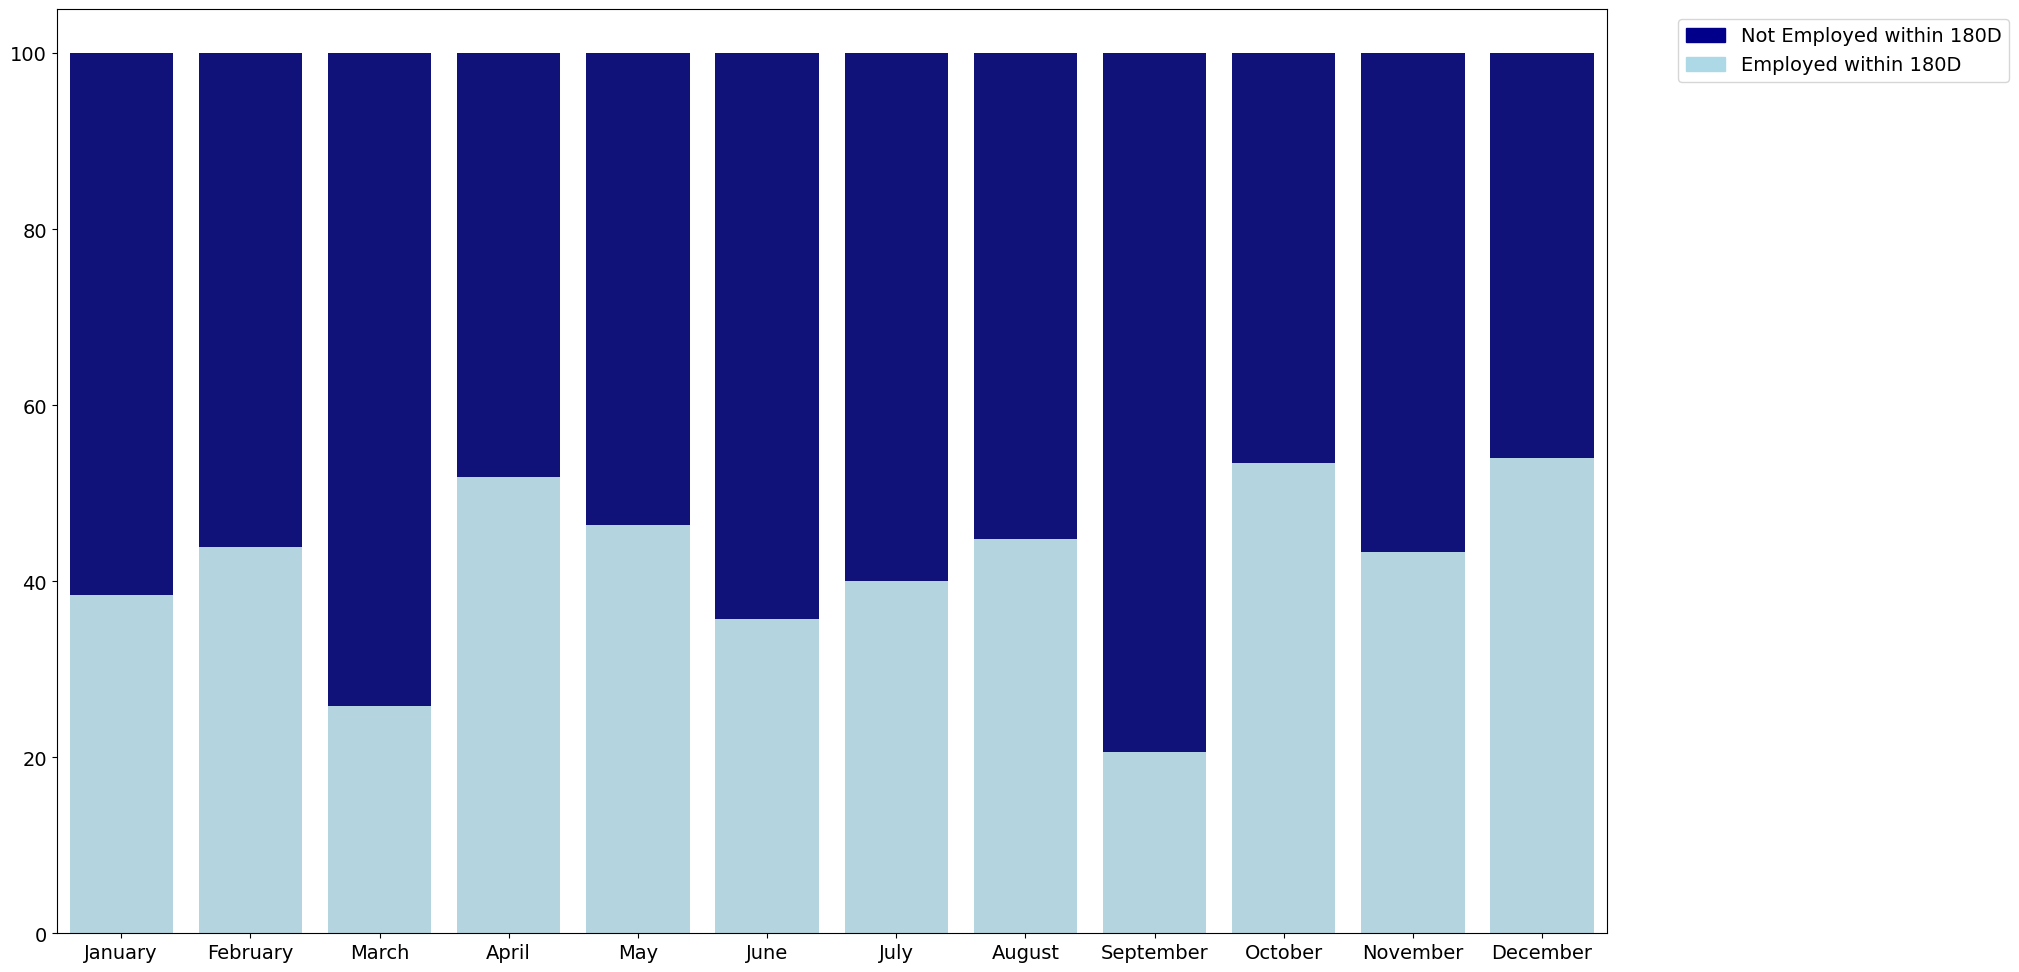

In [966]:
# Create a stacked bar chart:
import matplotlib.patches as mpatches

# set the figure size
fig = plt.figure(figsize=(20, 12))
ax = plt.subplot(111)

# from raw value to percentage
grads_per_graduation_month = gen_df.groupby('Graduation_month')['Student_ID'].count().reset_index()
num_placed_at180_per_month = gen_df.groupby('Graduation_month')["Employed_within_180D"].sum().reset_index()
num_placed_at180_per_month["Employed_within_180D"] = [i / j * 100 for i,j in zip(num_placed_at180_per_month["Employed_within_180D"], grads_per_graduation_month['Student_ID'])]
grads_per_graduation_month['Student_ID'] = [i / j * 100 for i,j in zip(grads_per_graduation_month['Student_ID'], grads_per_graduation_month['Student_ID'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="Graduation_month",  y="Student_ID", data=grads_per_graduation_month, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="Graduation_month", y="Employed_within_180D", data=num_placed_at180_per_month, color='lightblue')

# # add legend
top_bar = mpatches.Patch(color='darkblue', label='Not Employed within 180D')
bottom_bar = mpatches.Patch(color='lightblue', label='Employed within 180D')
plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor=(1.04, 1), loc="upper left")

# show the graph
plt.ylabel("")
plt.xlabel("")
plt.rcParams.update({'font.size': 14})
plt.show()

In [970]:
graduations_per_month = gen_df.groupby("Graduation_month")["Cohort_name"].nunique()
graduations_per_month

/var/folders/62/rv9lbyxx6l110tffps2wcg2r0000gn/T/ipykernel_25786/4113325734.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Graduation_month
January      17
February     13
March        13
April        22
May          13
June         22
July         11
August       16
September    14
October      13
November     15
December     13
Name: Cohort_name, dtype: int64

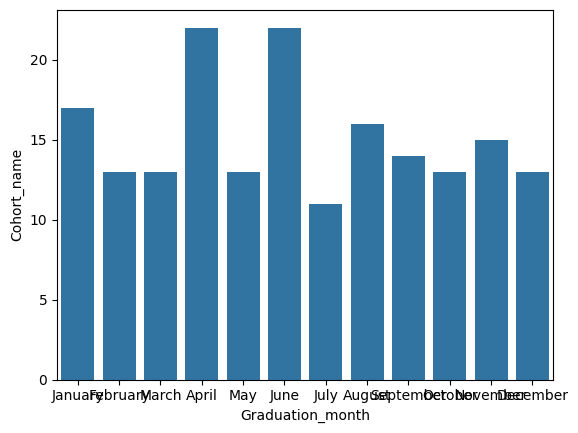

In [976]:
sns.barplot(x=graduations_per_month.index,
           y=graduations_per_month)

plt.rcParams.update({'font.size': 10})
plt.show()

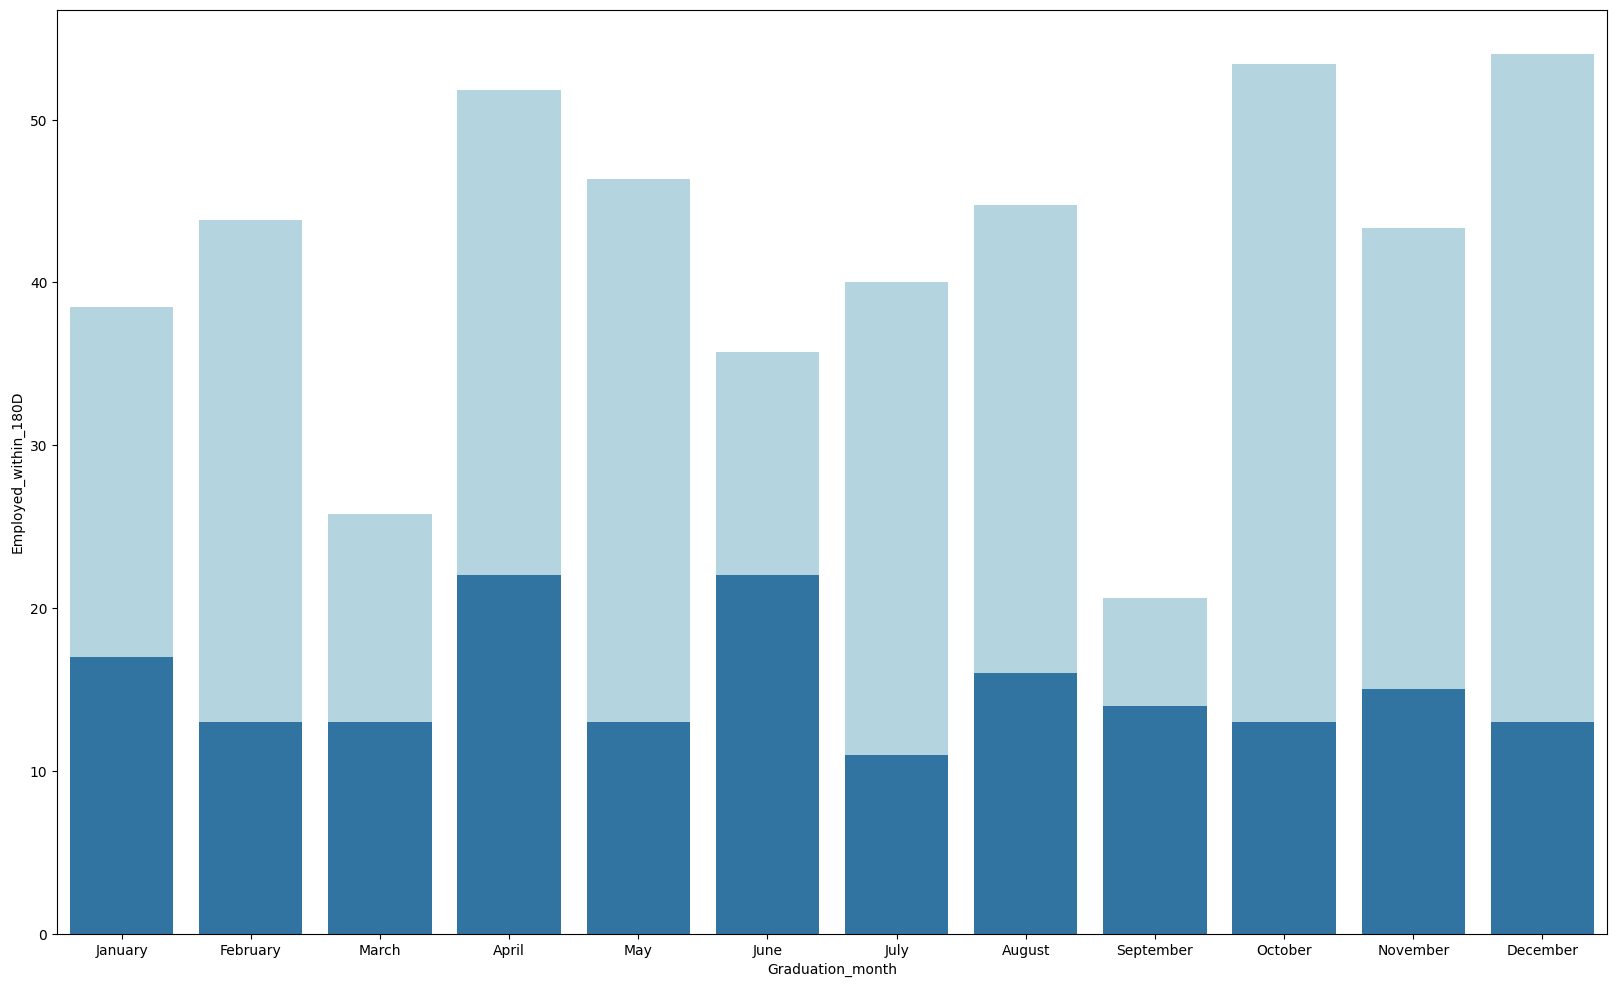

In [997]:
fig = plt.figure(figsize=(20, 12))
sns.barplot(x="Graduation_month", 
            y="Employed_within_180D", 
            data=num_placed_at180_per_month, 
            color='lightblue')
sns.barplot(x=graduations_per_month.index,
           y=graduations_per_month)

plt.show()

# 

In [ ]:
@interact
def histplot_col(column=list(gen_df.columns)):
    sns.histplot(y=gen_df[column],
                 hue=gen_df["gender_bool"])
    
    plt.title(f"Histogram of {column}")
    plt.show()

In [ ]:
# Other WIP stuff below:

In [ ]:
data = gen_df
input_features= ["Ethnicity_Group", "Employment_Status"]


source_, target_, value_, labels = Sankey_data_preprocessing(input_features, data, stop_points_)
Sankey_plot(source_, target_, value_, labels=labels, title_text_="Employment outcomes per race/ ethnic group")

In [ ]:
EAL_genders = gen_df[gen_df["is_EAL"]==1]["is_EAL"].groupby(gen_df["gender"]).count()
nonEAL_genders = gen_df[gen_df["is_EAL"]==0]["Student_ID"].groupby(gen_df["gender"]).count()

EAL_gender_df = pd.concat([EAL_genders, nonEAL_genders], axis=1)
EAL_gender_df.rename(columns = {"is_EAL":"Is EAL", "Student_ID":"Is not EAL"}, inplace=True)

EAL_gender_df.style.background_gradient(axis=None, low=0.5, high=1)

In [ ]:
test_df = gen_df.groupby(["gender","is_EAL"])["is_EAL"].count()
test_df

## Summary

This EDA has surfaced the following insights:




## Next steps

Direction for further analysis, questions to consider:
- Why are AWS learners much youger (on average) than the learners in other bootcamps. Is there room to expand admissions among learners over 30?
- What can Generation do to minimise the gap in Female+Non-binary learners and Male learners?
- Why are female generation students more likely to be EAL than male students?